In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline 
plt.style.use('ggplot')

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

In [73]:
## load data as time series 
df = pd.read_csv('a.us.txt', sep=",", 
                 header=0, 
                 index_col=0, 
                 parse_dates=True, 
                 squeeze=True)

In [74]:
df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1999-11-18,30.713,33.754,27.002,29.702,66277506,0
1999-11-19,28.986,29.027,26.872,27.257,16142920,0
1999-11-22,27.886,29.702,27.044,29.702,6970266,0
1999-11-23,28.688,29.446,27.002,27.002,6332082,0
1999-11-24,27.083,28.309,27.002,27.717,5132147,0


In [75]:
df['Close'].describe()

count    4521.000000
mean       27.871357
std        12.944389
min         7.323800
25%        19.089000
50%        24.490000
75%        36.521000
max       107.320000
Name: Close, dtype: float64

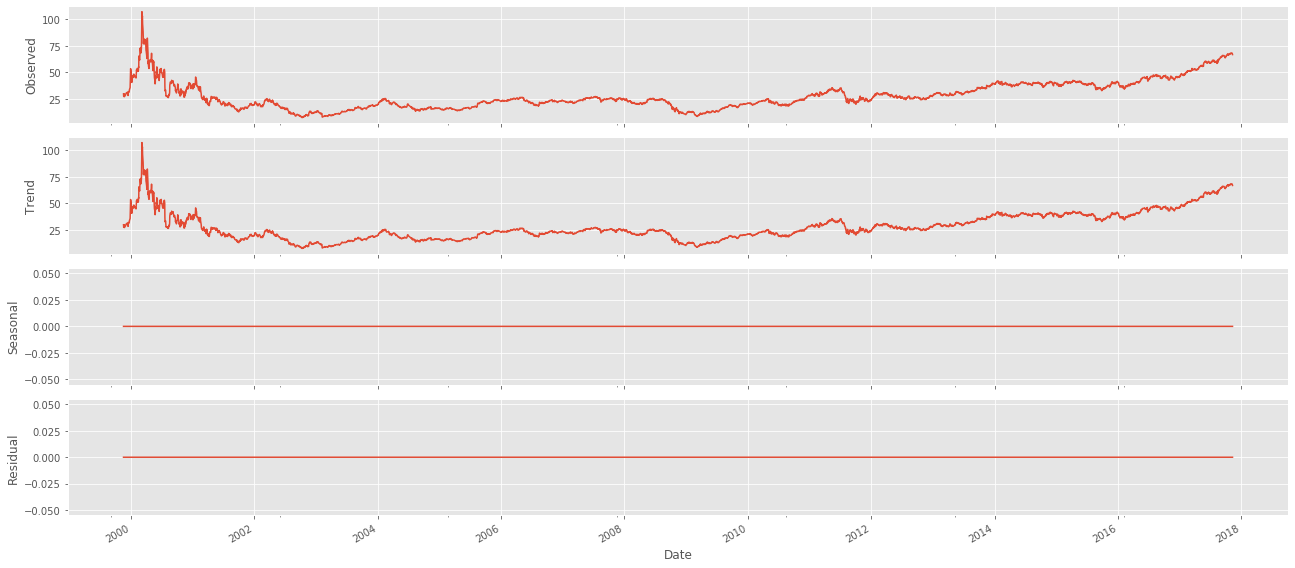

In [76]:
decompose = seasonal_decompose(df['Close'], model='additive', freq=1)

decompose.plot()
plt.show()

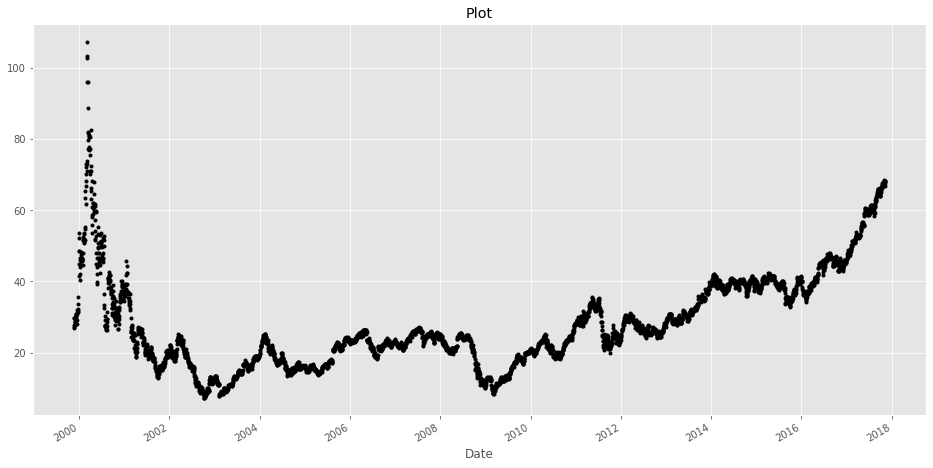

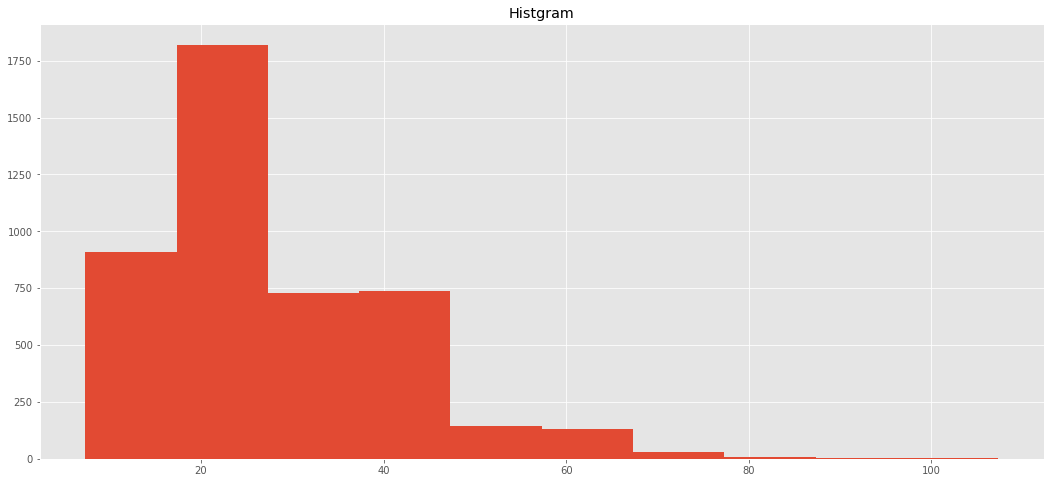

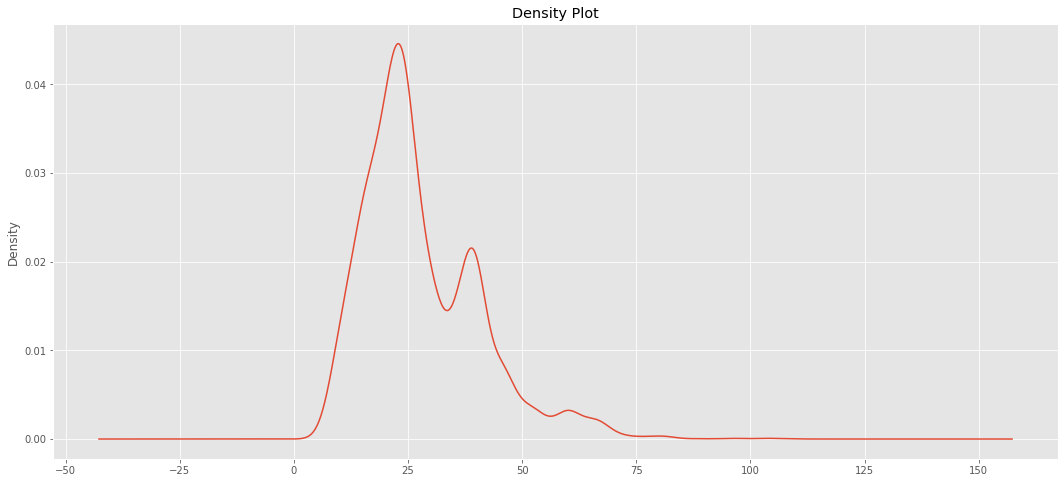

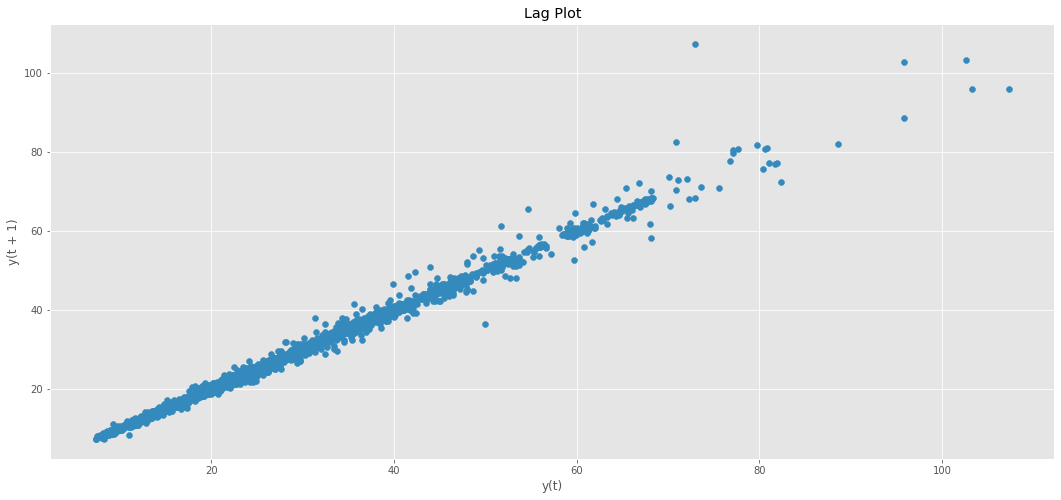

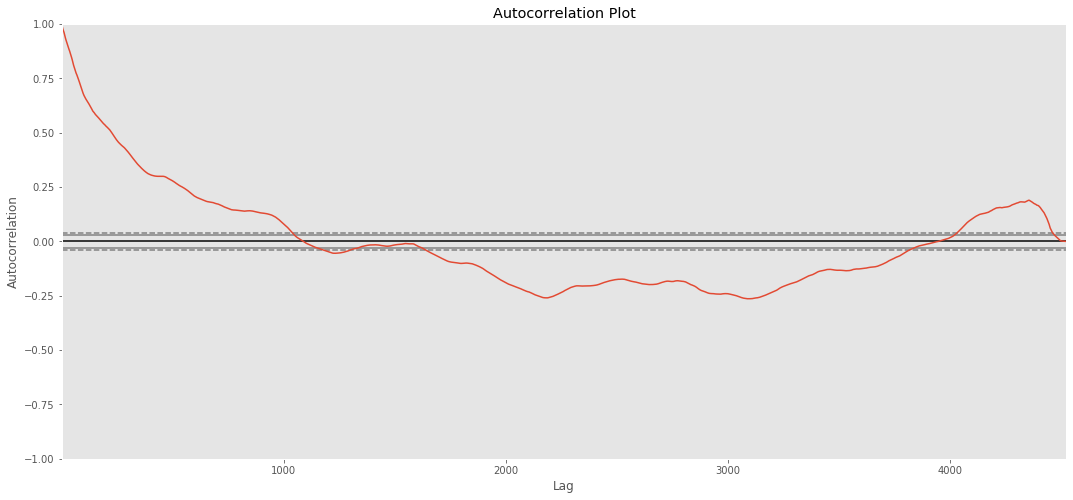

In [77]:
## visualize the dataset

df['Close'].plot(figsize=(16, 8), style='k.')
plt.title('Plot')
plt.show()

df['Close'].hist()
plt.title('Histgram')
plt.show()

df['Close'].plot(kind='kde')
plt.title('Density Plot')
plt.show()

pd.plotting.lag_plot(df['Close'])
plt.title('Lag Plot')
plt.show()

pd.plotting.autocorrelation_plot(df['Close'])
plt.title('Autocorrelation Plot')
plt.show()



### Downsampling

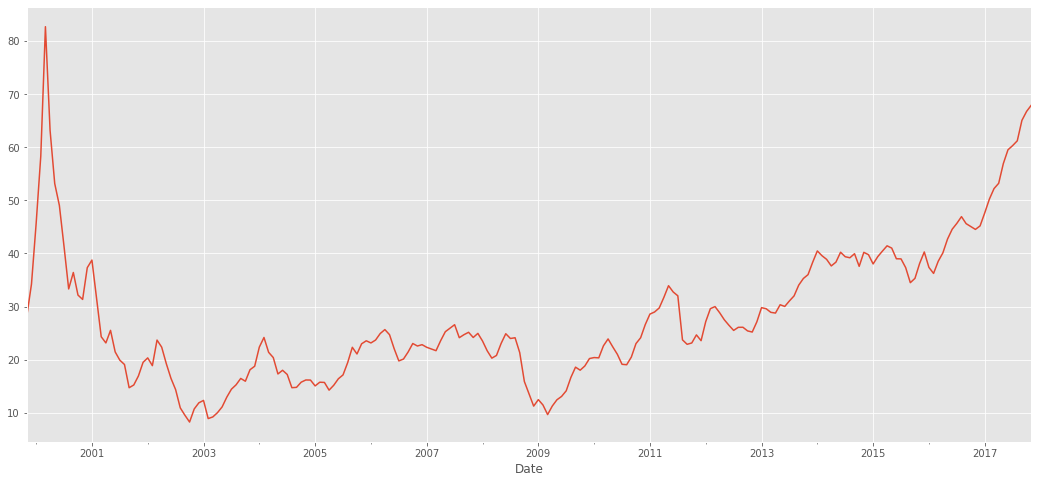

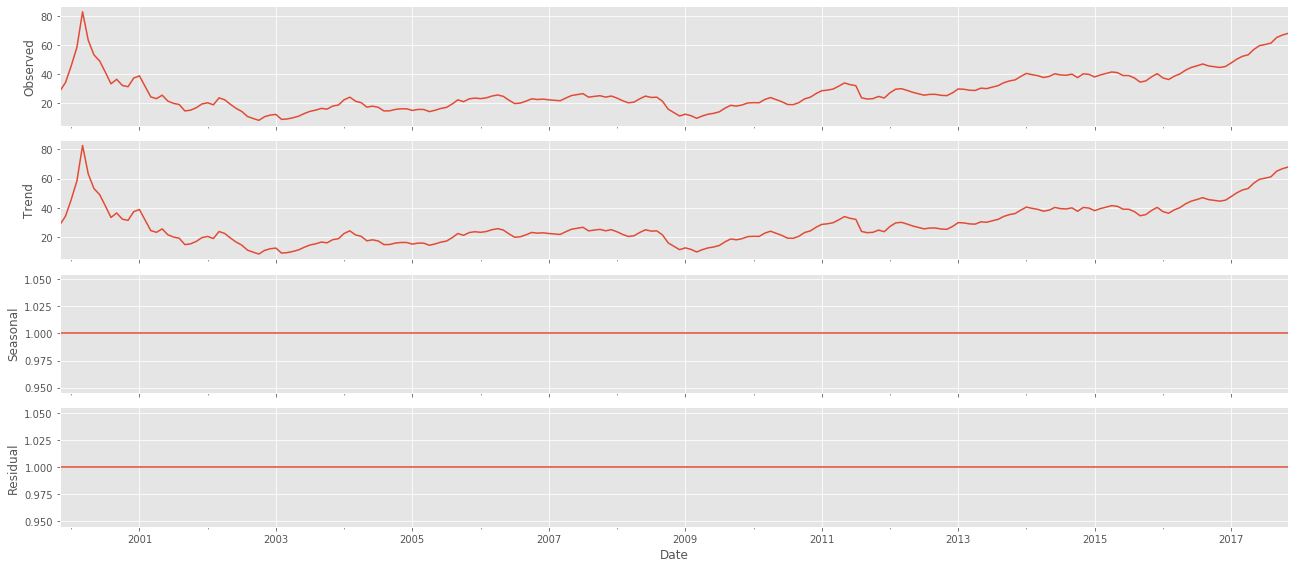

In [89]:
downsample = df['Close'].resample('M').mean()
downsample.plot()
plt.show()
results = seasonal_decompose(downsample, model='multiplicative', freq=1)
results.plot()
plt.show()

The data does not show seasonality, and decompose cannot catch the noise. 

## Build Persistence Model

In [78]:
X = df['Close'].values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()

for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
#     print(f'Prediciton = {round(yhat,3)}, Expected = {round(obs, 3)}')
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'RMSE: {round(rmse, 2)}')

RMSE: 0.5400000214576721


## ARIMA Models

In [79]:
from statsmodels.tsa.stattools import adfuller

In [80]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

series = df['Close']
X = series.values

stationary = difference(X)
stationary.index = series.index[1:]

result=adfuller(stationary)

print(f'ADF statistics: {round(result[0], 3)}')
print(f'p_value: {round(result[1], 5)}')
print('critical values')
for k, v in result[4].items():
    print(k, round(v,3))

ADF statistics: -13.538
p_value: 0.0
critical values
1% -3.432
5% -2.862
10% -2.567


In [81]:
stationary.to_csv('stationary_stock.csv', header=False)

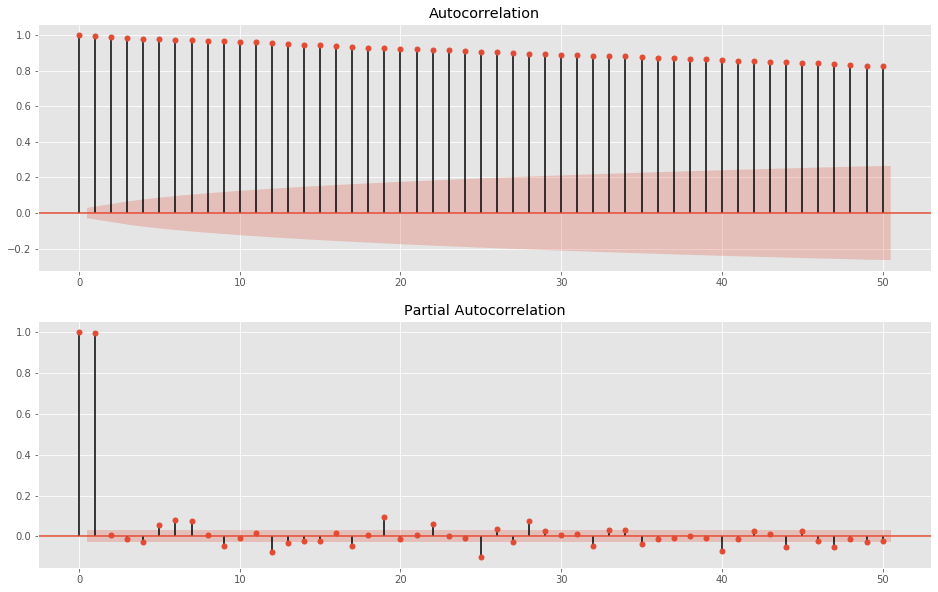

In [82]:
# ACF and PACF plots of time series:

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(16, 10))
plt.subplot(211)
plot_acf(df['Close'], lags=50, ax=plt.gca())

plt.subplot(212)
plot_pacf(df['Close'], lags=50, ax=plt.gca())

plt.show()

From the diffrencing, ACF, PACF, we can tell that the ARIMA with parameters of 1,1,1 might be the best.

In [83]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox

In [95]:
X = downsample.values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)



1.6987126327459308


In [84]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

In [96]:
X = downsample.values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    
    model = ARIMA(transformed, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    
    obs = test[i]
    history.append(obs)
    
#     print(f'Predicted={round(yhat, 3)}, Expected={round(obs, 3)}')
    
rsme = sqrt(mean_squared_error(test, predictions))
print(f'ERSM: {round(rsme, 3)}')   

ERSM: 1.673


In [98]:
import warnings

In [97]:
# grid search for p, d, q
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.5)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    prediction = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model.fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


def evaluate_models(dataset, ps, ds, qs):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in ps:
        for d in ds:
            for q in qs:
                order =(p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print(f'ARIMA: {order}, RMSE = {rmse}')
                except:
                    continue
    print(f'Best ARIMA: {best_cfg}, RMSE={best_score}')

In [ ]:
ps = range(0, 5)
ds = range(0, 4)
qs = range(0,5)

warnings.filterwarnings('ignore')
evaluate_models(downsample.values, ps, ds, qs)